In [48]:
#Binarization and Voxel Weight Calculation

In [46]:
# Initialize for download
from bossHandler import bossHandler
from intern.resource.boss.resource import *
from intern.remote.boss import BossRemote
from skimage import filters
import numpy as np
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import animation
import matplotlib.mlab as mlab
import glob
import skfmm
from scipy.ndimage.filters import laplace


In [ ]:
# Use ndpulled tiff files to load input data

# shape: (7074, 11628) = (y,x)
x_range = [5800 , 6200]
y_range = [2500 , 2800]
tifPath = '/run/mount/DRN-BLA_2378_2p_glycerol_Ch0/*.tif'
tifList = sorted(glob.glob(tifPath))
if tifList: # check if not empty
    im_slice = plt.imread(tifList[0])
    data_cutout = im_slice[y_range[0]:y_range[1] , x_range[0]:x_range[1]]
        
    if len(tifList)>1: # check if more than 1 file
        for tifFile in tifList[400:-1]:
            im_slice = plt.imread(tifFile)
            data_cutout = np.dstack((data_cutout, im_slice[y_range[0]:y_range[1] , x_range[0]:x_range[1]]))
            
# tifPath = '/run/mount/2ndbatch/*.tif'
# tifList = sorted(glob.glob(tifPath))
# if tifList: # check if not empty
# #     im_slice = plt.imread(tifList[0])
# #     data_cutout = im_slice[y_range[0]:y_range[1] , x_range[0]:x_range[1]]
        
#     if len(tifList)>0: # check if more than 0 files
#         for tifFile in tifList[0:300]:
#             im_slice = plt.imread(tifFile)
#             data_cutout = np.dstack((data_cutout, im_slice[y_range[0]:y_range[1] , x_range[0]:x_range[1]]))

In [ ]:
# Save data_cutout to file
# np.save('/run/local_data/x_5800-6200_y_2500-2800.npy',data_cutout)

In [2]:
# Load data_cutout from file
data_cutout_raw = np.load('/run/local_data/x_5800-6200_y_2500-2800.npy')

In [168]:
# apply gmm on whole data_cutout, slice by slice
# data_vol = np.copy(data_cutout)
gmm_nc = 4
vol_size = data_cutout_raw.shape
for i in np.arange(0 , vol_size[2]):
    data_slice = data_cutout_raw[:,:,i]
    uniq = np.unique(data_slice , return_counts=True)
    
    gmm = GaussianMixture(gmm_nc, covariance_type = 'full').fit(data_slice.reshape(-1,1))
    cluster_labels = gmm.predict(data_slice.reshape(-1,1))
    cluster_labels = cluster_labels.reshape(data_slice.shape)
    x = np.arange(0,uniq[1].shape[0])
    c_id = np.argmax(gmm.means_) # index of the cluster with highest mean
    
    data_slice[cluster_labels == c_id] = 1
    data_slice[cluster_labels != c_id] = 0
    data_cutout_raw[:,:,i] = data_slice
#     print(i)

In [ ]:
# Save binarized volume
# np.save('/run/local_data/x_5800-6200_y_2500-2800_binarized.npy',data_cutout)

In [3]:
# Load binarized volume
data_cutout_binarized = np.load('/run/local_data/x_5800-6200_y_2500-2800_binarized.npy')

In [4]:
from skimage.morphology import binary_opening, binary_closing, binary_dilation
# data_slice = np.copy(data_cutout[:,:,260])
# plt.imshow(data_slice)
# # data_slice = binary_closing(data_slice)
# data_slice = binary_dilation(data_slice)

# plt.figure()
# plt.imshow(data_slice)

# data_slice = binary_opening(data_slice)

# plt.figure()
# plt.imshow(data_slice)

# data_vol = np.copy(data_cutout)
# plt.imshow(data_vol[:,:,260])

data_cutout_binarized = binary_opening(data_cutout_binarized)

# plt.figure()
# plt.imshow(data_vol[:,:,260])


# for i in np.arange(0 , vol_size[2]):
#     data_slice = data_cutout[:,:,i]
#     data_slice = binary_opening()

In [5]:
data_cutout_binarized = data_cutout_binarized[:,:,70:180]
data_cutout_raw = data_cutout_raw[:,:,70:180]

In [6]:
print(data_cutout_binarized.shape)
print(data_cutout_raw.shape)

(300, 400, 110)
(300, 400, 110)


In [ ]:
# Use intern to load input data

# coll_name = 'ailey-dev'
# exp_name = 'Insula_Atenolol-1_171204_new'
# chan_name = 'Ch0'

# bHandler = bossHandler(coll_name)
# # bHandler.list_experiments()
# bHandler.select_experiment(exp_name)
# exp = bHandler.get_experiment()
# bHandler.list_channels()
# bHandler.select_channel(chan_name)
# coor = bHandler.get_coordinate_frame()


# download data from Boss
# data_cutout = bHandler.get_all()
# coor = bHandler.get_coordinate_frame()
# x_rng = [348, 500]
# y_rng = [678, 878]
# z_rng = [coor.z_start, coor.z_stop]

# data_cutout = bHandler.get_cutout(x_rng, y_rng, z_rng)

# data_cutout = data_cutout.astype('uint16')

534.0
4095
0.0


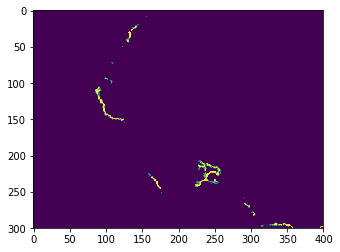

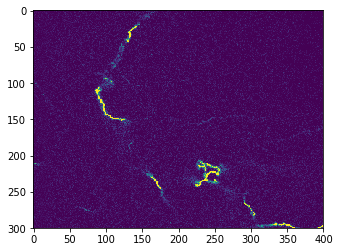

In [9]:
ttt = tractography(data_cutout_binarized , data_cutout_raw)
w1 = ttt.compute_w1()
print(np.min(w1))
# print(ttt.masked_vol.shape)
plt.figure()

sn = 81

# plt.imshow(w1[:,:,sn])
# plt.colorbar()

plt.figure()
plt.imshow(ttt.masked_vol[:,:,sn])
plt.figure()
plt.imshow(data_cutout_raw[:,:,sn])

In [ ]:
ttt = tractography(data_cutout_binarized , data_cutout_raw)
w1 = ttt.compute_w1()
print(np.min(w1))
# print(ttt.masked_vol.shape)
plt.figure()
plt.imshow(w1[200:250,220:260,81])
plt.colorbar()

plt.figure()
plt.imshow(ttt.masked_vol[200:250,239,60:100])

plt.figure()
plt.imshow(data_cutout_raw[200:250,239,60:100])
plt.figure()
plt.imshow(data_cutout_raw[200:250,220:260,81])


In [ ]:
ttt = tractography(data_cutout_binarized , data_cutout_raw)
w2 = ttt.compute_w2()


In [ ]:
print(w2.shape)

plt.imshow(w2[:,:,50])
plt.colorbar()

In [35]:
ttt = tractography(data_cutout_binarized , data_cutout_raw)
w3 = ttt.compute_w3()




(300, 400, 110)


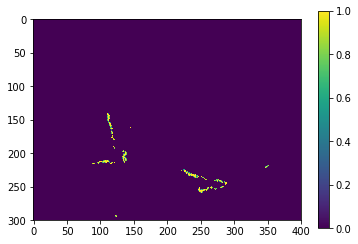

In [36]:
print(w3.shape)
plt.imshow(w3[:,:,50])
plt.colorbar()

In [29]:
print(np.min(w3))

-0.973905261368


In [37]:
ttt = tractography(data_cutout_binarized , data_cutout_raw)
vw = ttt.compute_vertex_wight()

534.0
4095


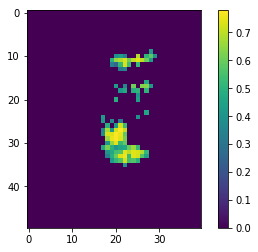

In [38]:
plt.imshow(vw[200:250,239,60:100])
plt.colorbar()


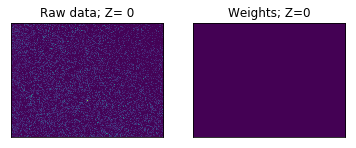

In [39]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,80]
fig, (im1, im2) = plt.subplots(1, 2)

# fig.set_facecolor('black')
ax1 = im1.imshow(data_cutout_raw[:,:,0], animated=True)
ax2 = im2.imshow(vw[:,:,0], animated=True)

im1.get_xaxis().set_visible(False)
im2.get_xaxis().set_visible(False)

im1.get_yaxis().set_visible(False)
im2.get_yaxis().set_visible(False)

im1.set_title('Raw data')
im2.set_title('Weights')

def animate(i):
    ax1.set_data(data_cutout_raw[:,:,i])
    im1.set_title('Raw data; Z= ' + str(i))
#     ax1.set_cmap('gray')
    ax1.autoscale()
    
    ax2.set_data(vw[:,:,i])
    im2.set_title('Weights; Z=' + str(i))
#     ax2.set_cmap('gray')
    ax2.autoscale()
    return ax1

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 50)
HTML(anim.to_jshtml())
# ffwriter = animation.FFMpegWriter(fps=15)
# anim.save('side-by-side_fps15_grey.mp4', dpi=300, writer=ffwriter)

In [ ]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(data_cutout_raw[:,:,50])

plt.subplot(1,2,2)
plt.imshow(vw[:,:,50])

plt.g

In [ ]:
ttt.masked_vol.shape

In [ ]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , vw.shape[2]]
# z_rng = [70,180]
fig = plt.figure()
im = plt.imshow(vw[:,:,0], animated=True)

def animate(i):
    im.set_data(vw[:,:,i])
    im.autoscale()
    return im

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 100)
# HTML(anim.to_jshtml())
anim.save('vertex-weights_subvol.mp4', dpi=80, writer=ffwriter)

In [ ]:
# Visualize the output (animation)
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML

z_rng = [0 , data_cutout_raw.shape[2]]
# z_rng = [70,180]
fig = plt.figure()
im = plt.imshow(data_cutout_raw[:,:,0], animated=True)

def animate(i):
    im.set_data(data_cutout_raw[:,:,i])
#     im.set_cmap('YlOrRd')
    im.autoscale()
    return im

anim = animation.FuncAnimation(fig, animate, frames = np.arange(z_rng[0],z_rng[1]), interval = 100)
HTML(anim.to_jshtml())
# anim.save('subvol_raw.mp4', dpi=80, writer=ffwriter)

In [ ]:
print(vw.dtype)
vw = vw*100
print(vw.dtype)
vw = np.uint16(vw)
print(data_cutout_raw.shape)

In [ ]:
from tifffile import imsave

imsave('vertexWeight_uint16.tiff', vw)
# imsave('data_cutout_raw.tiff', data_cutout_raw)


In [34]:
class tractography:
    def __init__(self, mask , vol):
        '''
        Constructor
        '''
        self.mask = np.copy(mask) # binarized volume
        self.masked_vol = np.copy(vol)
        self.masked_vol[self.mask == 0] = 0
        
        

    def compute_w1(self):
        '''
        Compute W1 for vertex weight computation
        '''
        min_intensity = np.float64(np.min(self.masked_vol[self.masked_vol !=0 ]))
        print(min_intensity)
        max_intensity = np.max(self.masked_vol)
        print(max_intensity)
        w1 = np.copy(self.masked_vol)
        w1 = (w1 - min_intensity)/(max_intensity - min_intensity)
        w1[w1 < 0] = 0

        return w1
    
    def compute_w2(self):
        '''
        Compute W2 for vertex weight computation; Distance from boundaries.
        '''
        w2 = np.copy(self.masked_vol)
        w2 = skfmm.distance(w2)
        min_distance = np.float64(np.min(w2[w2 != 0]))
        max_distance = np.max(w2)
        w2 = (w2 - min_distance)/(max_distance - min_distance)
        w2[w2 < 0] = 0
        
        return w2
    
    def compute_w3(self):
        '''
        Compute W3 for vertex weight computation; Laplacian of edges
        '''
        w2 = self.compute_w2()
        lplc = laplace(w2)
        lplc = np.tanh(2.0*lplc)
        w3 = np.minimum(np.ones(lplc.shape) , 1.0 - lplc)
        w3[self.mask == 0] = 0
        return w3
        
    def compute_vertex_wight(self):
        '''
        Compute vetex weight (average of w1, w2, and w3)
        '''
        w1 = self.compute_w1()
        w2 = self.compute_w2()
        w3 = self.compute_w3()
        
        vw = (w1 + w2 + w3)/3.0
#         vw[self.mask == 0] = 0
        
        return vw
            